# Single adaptive Kramers chain

Start from recalling the SDE for one bead in a chains:

\begin{equation}
\mathrm{d}X_i =\left(X_i\nabla U + \frac{g_i}{\zeta_i\ell_i} Q_i - \frac{g_{i-1}}{\zeta_i\ell_{i-1}}Q_{i-1}\right)\mathrm{d}t + \mathrm{d}W_i
\end{equation}

$\mathrm{d}W_i$ are drawn from a normal distribution with zero mean and variance $2 kT \mathrm{d}t/\zeta_i$ per each coordinate. The SDE for each rod will be:

\begin{equation}
\mathrm{d}Q_i =\left(Q_i\nabla U + \frac{g_{i-1}}{\zeta_i\ell_{i-1}}Q_{i-1} - \left( \frac{1}{\zeta_{i+1}} + \frac{1}{\zeta_i}\right)\frac{g_i}{\ell_i} Q_i + \frac{g_{i+1}}{\zeta_{i+1}\ell_{i+1}}Q_{i+1}\right)\mathrm{d}t + \mathrm{d}W_{i+1}-\mathrm{d}W_{i}
\end{equation}

This system holds also in dimensionless form where $\ell_i=1$ and $\zeta_i=1$ for unit beads and rods. Merging rods gives integers $\ell_i$, but we have options for the dimensionless friction. Here we choose to balance the weight of beads on both sides:

\begin{equation}
\zeta_i = \frac{\ell_{i-1}+\ell_{i}}{2}
\end{equation}

with the convention $\ell_{-1}=\ell_{i+1}=1$ at chain ends. Since the contour length is constant and is given by $\sum \ell_i=N$, we can check that in this way $\sum\zeta_i=N+1$, so the chain has always the same total friction as a regular Kramers chain of $N+1$ beads.

The left-hand side of the tridiagonal system for the tension is now:

\begin{equation}
- g_{i-1}\frac{Q_{i-1}\cdot Q_i}{\zeta_i\ell_{i-1}} + \left( \frac{\ell_i}{\zeta_{i+1}} + \frac{\ell_i}{\zeta_i}\right)g_i - g_{i+1}\frac{Q_{i+1}\cdot Q_i}{\zeta_{i+1}\ell_{i+1}} =\left( Q_i\nabla U + \frac{\mathrm{d}W_{i+1} -\mathrm{d}W_{i}}{\mathrm{d}t}\right) \cdot Q_i + \frac{\mathrm{d}Q_i^2}{2\mathrm{d}t}
\end{equation}



In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate
from dilutebrowniandynamics.molecules.adaptive_Kramers_chain import AdaptiveKramersChain
np.random.seed(2022)

## Parameters definition

In [2]:
n_links = 1000       # Number of segments in the Kramers chain

n_rec = 2000        # Number of time steps to record
dt = .001           # Time step value (dimensionless)
n_proc = 16         # Number of processor cores to use

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
# Starting vectors
molecule = AdaptiveKramersChain.from_normal_distribution(n_links)

We can plot this molecule using matplotlib 3d capabilities: firt we need to convert links to coordinates.

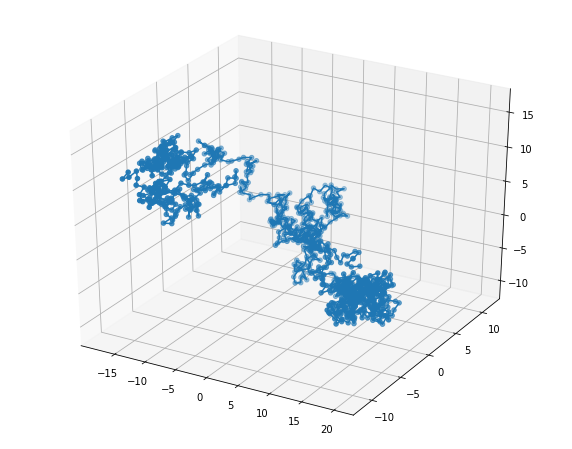

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xyz = molecule.coordinates
x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
ax.plot(x, y, z)
ax.scatter(x, y, z, s=20)

Or we can export the molecule to vtk format which can be read by Paraview.

In [5]:
molecule.save_vtk('outputs/vtk/example.vtk')

## Initial relaxation
Thermalisation step.

In [6]:
gradU = np.zeros((3, 3))
observables, molecule_out = simulate(molecule, gradU, n_rec, dt, full_trajectory=False, progress=True)

100%|██████████| 2000/2000 [00:03<00:00, 572.20it/s]


## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [7]:
from scipy.interpolate import interp1d
t_base = [0, # Elongation starts at t = 0
          5] # Relaxation will start from t = 5
gradU_base = [np.diag([1, -.5, -.5]),
              np.zeros((3, 3))]
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [8]:
n_rec = 10_000
observables, trajectory = simulate(molecule_out, gradU, n_rec, dt, full_trajectory=True, progress=True)

100%|██████████| 10000/10000 [05:39<00:00, 29.45it/s]


In [9]:
#%load_ext line_profiler
#%lprun -f AdaptiveKramersChain.solve molecule_out.solve(np.zeros((3, 3)), dt)

## Analysing tensions in the molcule
Save a sequence of vtk files to make an animation in Paraview:

In [10]:
for i in range(0,len(trajectory),100):
    trajectory[i].save_vtk(f'outputs/vtk/time_{i}.vtk')

To see how the molecule unravels, we can plot tension as function of time in a 2d plot:

In [11]:
mat = np.empty((n_rec,n_links))
for i in range(n_rec):
    mat[i] = trajectory[i].tensions
    
plt.matshow(np.log(abs(mat)), aspect=0.1)

ValueError: could not broadcast input array from shape (998,) into shape (1000,)

In [ ]:
#%load_ext line_profiler

#%lprun -f KramersChain.evolve molecule_out.evolve(np.diag([1, -.5, -.5]), 0.00001)